In [194]:
from omegaconf import OmegaConf
from vitssm.models import build_model
from vitssm.data import get_dataset
import torch
from vitssm.utils.visual import model_output_to_video, display_video_frames_in_grid, save_videos_as_grid_gif
from einops import rearrange, repeat
from torchvision.io import write_video
import imageio
import matplotlib.pyplot as plt
import numpy as np

config = OmegaConf.load("/home/david/projects/ViTSSM/configs/UPT/FINAL_upt_3d_t_cont_config.yml")
config.dataset.load_in_memory = False
config.dataset.mode = "test"
config.dataset.resolution = 32
config.dataset.clip_length = 36
config.model.upt_autoencoder_checkpoint_path = "/home/david/projects/ViTSSM/checkpoints/ContVidPred/UPT/vmdsprites-0-UPT_VAE_T-cont-scale.pth"

upt_model = build_model(config.model)
dataset = get_dataset(config.dataset)

app_checkpoint_path = "/home/david/projects/ViTSSM/checkpoints/ContVidPred/UPT/vmdsprites-0-UPT_3D_T-cont-scale.pth"
ckpt = torch.load(app_checkpoint_path)
app_ckpt = {key[13:]: val for key, val in ckpt["model"].items() if key.startswith("approximator")}

upt_model.approximator.load_state_dict(app_ckpt)

unet_config = OmegaConf.load("/home/david/projects/ViTSSM/configs/UNET/FINAL_unet_t_32_config.yml")
unet_config.dataset.load_in_memory = False
unet_config.dataset.mode = "test"
unet_config.dataset.resolution = 32
unet_config.model.timestep_respacing = "trailing4"

unet_model = build_model(unet_config.model)
unet_ckpt = torch.load("/home/david/projects/ViTSSM/checkpoints/ContVidPred/UNET/vmdsprites-0-UNet_T-32.pth")
unet_model.load_state_dict(unet_ckpt["model"])

dit_config = OmegaConf.load("/home/david/projects/ViTSSM/configs/DIT/FINAL_dit_t_2_32_config.yml")
dit_config.dataset.load_in_memory = False
dit_config.dataset.mode = "test"
dit_config.dataset.resolution = 32
dit_config.model.timestep_respacing = "trailing4"

dit_model = build_model(dit_config.model)
dit_ckpt = torch.load("/home/david/projects/ViTSSM/checkpoints/ContVidPred/DIT/vmdsprites-0-DiT_T_2-32.pth")
dit_model.load_state_dict(dit_ckpt["model"])


/home/david/projects/ViTSSM/vitssm/models/upt/_next_frame.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(upt_autoencoder_checkpoint_path)
/tmp

<All keys matched successfully>

In [195]:
x = dataset[50]
x, y = x[0].unsqueeze(0), x[1].unsqueeze(0)
print(x.shape, y.shape)

torch.Size([1, 4, 3, 32, 32]) torch.Size([1, 32, 3, 32, 32])


# Rollout comparison

In [203]:
from vitssm.utils.visual import model_output_to_video, display_video_frames_in_grid
from einops import rearrange, repeat
from torchvision.io import write_video
import imageio
import numpy as np

bs, cl, ch, ht, wt = x.shape
spatial_scale = 1
temporal_scale = 1
n_steps = 32
device = torch.device("cuda")


upt_model.eval()
upt_model.to(device)
unet_model.eval()
unet_model.to(device)
dit_model.eval()
dit_model.to(device)

x_pred_upt_1 = rearrange(
    model_output_to_video(
        upt_model.rollout_frames(x.to(device), n_steps=n_steps, temporal_scale=temporal_scale, spatial_scale=1).squeeze(0).cpu(),
    ),
    "... c h w -> ... h w c",
)

#x_pred_upt_2 = rearrange(
#    model_output_to_video(
#        upt_model.rollout_frames(x.to(device), n_steps=n_steps, temporal_scale=temporal_scale, spatial_scale=2).squeeze(0).cpu(),
#    ),
#    "... c h w -> ... h w c",
#)
#
#x_pred_upt_3 = rearrange(
#    model_output_to_video(
#        upt_model.rollout_frames(x.to(device), n_steps=n_steps, temporal_scale=temporal_scale, spatial_scale=3).squeeze(0).cpu(),
#    ),
#    "... c h w -> ... h w c",
#)
#
#x_pred_upt_4 = rearrange(
#    model_output_to_video(
#        upt_model.rollout_frames(x.to(device), n_steps=n_steps, temporal_scale=temporal_scale, spatial_scale=4).squeeze(0).cpu(),
#    ),
#    "... c h w -> ... h w c",
#)
x_pred_unet = rearrange(
    model_output_to_video(
        unet_model.rollout_frames(x.to(device), n_steps=n_steps, alpha_cond_aug=0.0).squeeze(0).cpu(),
    ),
    "... c h w -> ... h w c",
)

x_pred_dit = rearrange(
    model_output_to_video(
        dit_model.rollout_frames(x.to(device), n_steps=n_steps).squeeze(0).cpu(),
    ),
    "... c h w -> ... h w c",
)

y = rearrange(
    model_output_to_video(
        y.squeeze(0).cpu(),
    ),
    "... c h w -> ... h w c",
)

#save_videos_as_grid_gif([x_pred_upt], (1, 1), "upt_x_pred.gif")
#save_videos_as_grid_gif([x_pred_unet], (1, 1), "unet_x_pred.gif")
#save_videos_as_grid_gif([x_pred_dit], (1, 1), "dit_x_pred.gif")

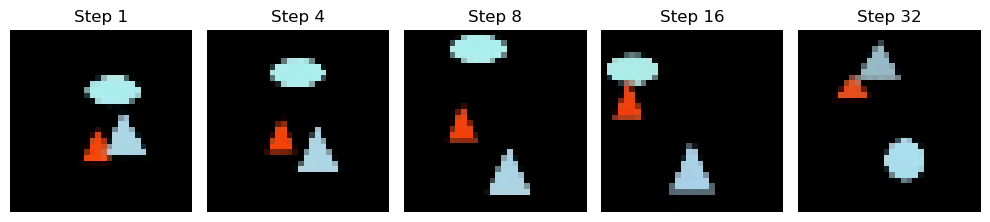

In [210]:
import matplotlib.pyplot as plt

def plot_video_frames(video_array, frame_indices, output_size=None):
    """
    Plots specified frames from a video (stored as a NumPy array) in a row.

    Args:
        video_array (numpy.ndarray): The video array of shape (num_frames, height, width, channels).
        frame_indices (list of int): List of frame indices to plot.
        output_size (tuple, optional): Target size (width, height) for resizing frames. Default is None.
    """
    # Validate inputs
    if video_array.ndim != 4:
        raise ValueError("Video array must have 4 dimensions: (num_frames, height, width, channels).")
    
    num_frames, height, width, channels = video_array.shape
    if channels not in (1, 3):
        raise ValueError("Video array must have 1 (grayscale) or 3 (RGB) channels.")
    
    if any(idx >= num_frames for idx in frame_indices):
        raise ValueError(f"Frame indices must be less than the total number of frames ({num_frames}).")

    # Extract specified frames
    frames = [video_array[idx] for idx in frame_indices]

    # Plot the frames in a row
    fig, axes = plt.subplots(1, len(frames), figsize=(10, 5))
    for ax, frame, idx in zip(axes, frames, frame_indices):
        if channels == 1:
            ax.imshow(frame.squeeze(), cmap='gray')  # Grayscale
        else:
            ax.imshow(frame)  # RGB
        ax.set_title(f"Step {idx+1}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


plot_video_frames(x_pred_dit, [0, 3, 7, 15, 31])

In [227]:
from thop import profile, clever_format
import torch



class ProfileWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x, steps, *args):
        return self.model.rollout_frames(x, steps, *args)
    
    
macs, params = profile(ProfileWrapper(dit_model), inputs=(x.cuda(), 32))
macs, params = clever_format([macs, params], "%.3f")
print('MACs = ' + macs)
print('Params = ' + params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
MACs = 155.965G
Params = 3.654M


# Latent Space Similarity

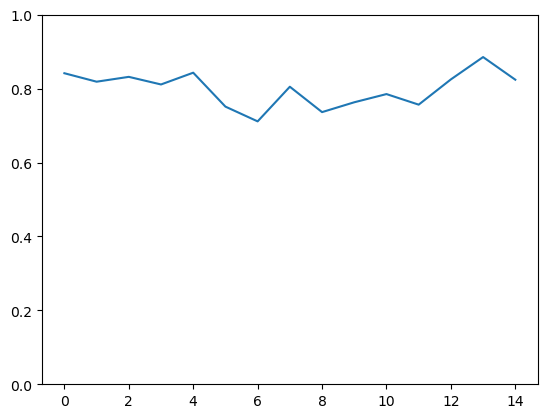

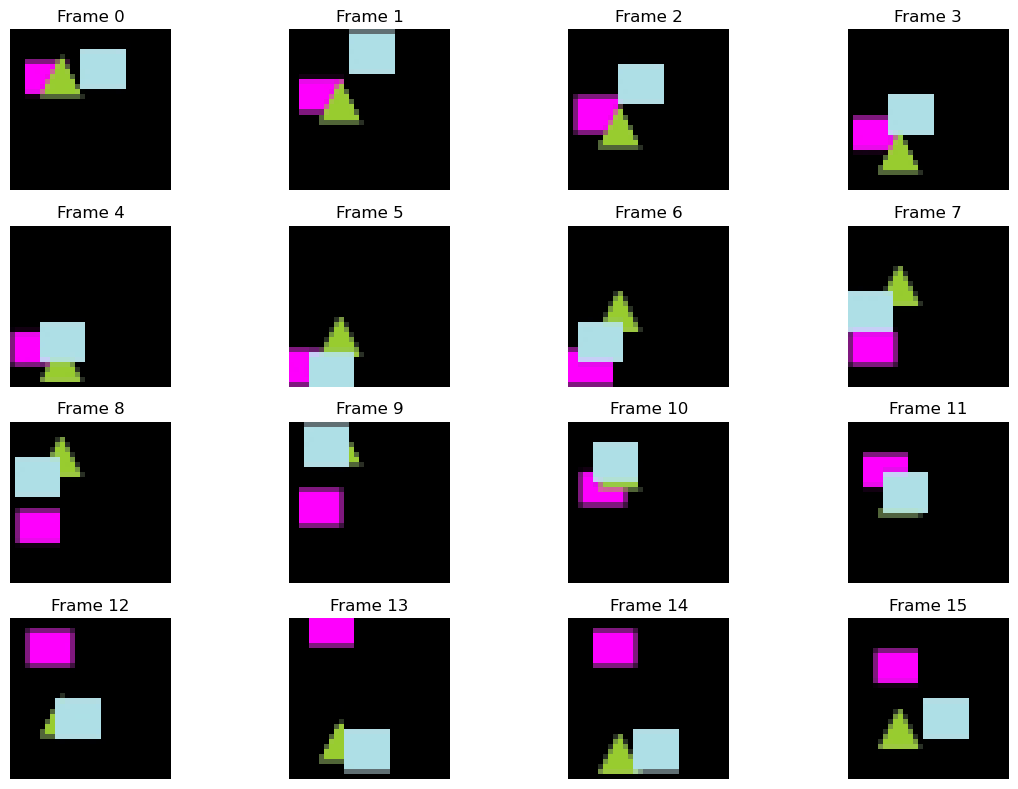

torch.Size([16, 4, 3, 32, 32])
Saved GIF to cos_sims.gif


In [69]:
from torch.nn.functional import cosine_similarity

config.dataset.num_frames = 64
config.dataset.context_length = 64
dataset = get_dataset(config.dataset)

x = dataset[90]
x = torch.split(x[0].unsqueeze(0), 4, dim=1)
x = torch.cat(x, dim=0)

z = model.autoencoder.encode(x.to(device))

cos_sims = [cosine_similarity(z[i], z[i+1], dim=-1).mean().cpu() for i in range(x.size(0) - 1)]

plt.plot(range(x.size(0) - 1), cos_sims, scaley=False)
display_video_frames_in_grid(x[:, 1])

cos_sims.append(torch.tensor(0.0))
print(x.shape)
x_weighted = x * torch.tensor(cos_sims).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

x = model_output_to_video(rearrange(x, "b t c h w -> (b t) h w c"))
x_weighted = model_output_to_video(rearrange(x_weighted, "b t c h w -> (b t) h w c"))
save_videos_as_grid_gif([x, x_weighted], (1, 2), "cos_sims.gif")

TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'Tensor'

# Super-Resolution

In [41]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def compare_model_upsampling(tensor, model_outputs, model_names, target_size):
    """
    Compare bilinear upsampling visually across multiple model outputs.

    Args:
        tensor (torch.Tensor): Input image tensor in C, H, W format.
        model_outputs (list of torch.Tensor): List of model output tensors in C, H, W format.
        model_names (list of str): Names of the models corresponding to the outputs.
        target_size (tuple): Target size as (height, width).
    """
    # Ensure the tensor is in C, H, W format
    if tensor.ndim != 3:
        raise ValueError("Input tensor must be in C, H, W format.")

    # Ensure model_outputs and model_names lengths match
    if len(model_outputs) != len(model_names):
        raise ValueError("model_outputs and model_names must have the same length.")

    # Normalize tensors for visualization
    tensor = tensor / tensor.max()
    model_outputs = [model / model.max() for model in model_outputs]

    # Convert to PIL images for compatibility with transforms
    to_pil = transforms.ToPILImage()
    pil_image = to_pil(tensor)
    model_images = [to_pil(model) for model in model_outputs]

    # Bilinear interpolation transform
    bilinear_transform = transforms.Resize(target_size, interpolation=transforms.InterpolationMode.BILINEAR)

    # Create subplots: Original + one for each model
    fig, axes = plt.subplots(1, len(model_outputs) + 1, figsize=(8, 4))

    # Show the original image with bilinear interpolation
    original_resized = bilinear_transform(pil_image)
    axes[-1].imshow(original_resized)
    axes[-1].set_title("Bilinear Interpolation")
    axes[-1].axis("off")

    # Show the resized images for each model output
    for ax, model_image, model_name in zip(axes[:-1], model_images, model_names):
        resized_image = bilinear_transform(model_image)
        ax.imshow(resized_image)
        ax.set_title(model_name)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_963/115169400.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  srno_model.load_state_dict(torch.load("/home/david/projects/ViTSSM/checkpoints/ContVidPred/

tensor(-1.) tensor(1.)


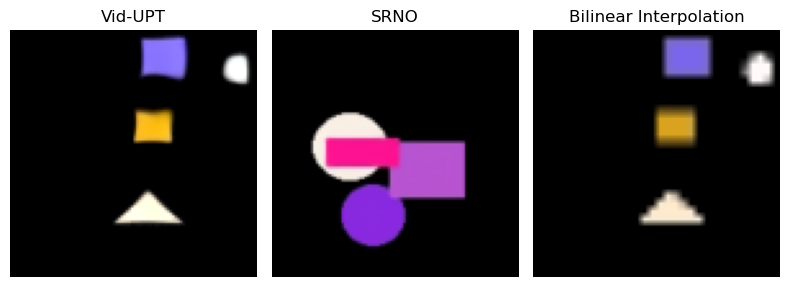

In [63]:
from vitssm.data.datasets import VideoDataset, VideoFrameDataset
from vitssm.utils.visual import unnormalize, model_output_to_video
from torchvision.transforms.functional import resize
from omegaconf import OmegaConf
from vitssm.models import build_model
from einops import rearrange
from vitssm.data.wrappers import SRImplicitDownsampledFast

dataset = VideoDataset("data_store/VMDsprites_128/folds/train_0.csv", 32, clip_length=4, frame_interval=4, image_size=(32, 32))

srno_dataset = VideoFrameDataset("data_store/VMDsprites_128/folds/train_0.csv", 32, image_size=(32, 32), transform_name=None)
srno_dataset = SRImplicitDownsampledFast(srno_dataset, scale_min=4, scale_max=4, train=False)

srno_config = OmegaConf.load("configs/SRNO/FINAL_srno_edsr_config.yml")
srno_model = build_model(srno_config.model)
srno_model.load_state_dict(torch.load("/home/david/projects/ViTSSM/checkpoints/ContVidPred/SRNO/vmdsprites-0-SRNO-EDSR.pth")["model"])
srno_model.eval()
srno_model.requires_grad_(False)
srno_model.to("cuda")

upt_config = OmegaConf.load("configs/UPT/FINAL_upt_vae_t_cont_config.yml")
upt_model = build_model(upt_config.model)
upt_model.load_state_dict(torch.load("/home/david/projects/ViTSSM/checkpoints/ContVidPred/UPT/vmdsprites-0-UPT_VAE_T-cont-scale.pth")["model"])
upt_model.eval()
upt_model.decoder.unbatch_mode = "video"
upt_model.requires_grad_(False)

x = dataset[1500][0:4]

t, c, h, w = x.shape
rescale_factor = 3

output_pos = rearrange(
    torch.stack(torch.meshgrid([torch.arange(t), torch.arange(h * rescale_factor), torch.arange(w * rescale_factor)], indexing="ij")),
    "ndim time height width -> (time height width) ndim",
).float()

dims = torch.tensor([t, h * rescale_factor, w * rescale_factor])
output_pos = output_pos / (dims - 1) * 1000

x_pred = upt_model(x.unsqueeze(0), output_pos.unsqueeze(0))

x_pred = unnormalize(x_pred[0][0]) * 255
x = unnormalize(x[0]) * 255

inp, coord, cell, gt = srno_dataset[0].values()

pred_srno = srno_model(inp.unsqueeze(0).cuda(), coord.unsqueeze(0).cuda(), cell.unsqueeze(0).cuda()).cpu().clamp(-1, 1)
print(pred_srno.min(), pred_srno.max())
pred_srno = unnormalize(pred_srno[0]) * 255

compare_model_upsampling(x, [x_pred, pred_srno], ["Vid-UPT", "SRNO"], target_size=(32 * rescale_factor, 32 * rescale_factor))

# Plotting

In [71]:
import matplotlib.pyplot as plt
import numpy as np

def plot_psnr_over_scales(scales, psnr_values, model_names, title="PSNR over Super-Resolution Scales"):
    """
    Plots PSNR over super-resolution scales for multiple models.
    
    Args:
        scales (list): Super-resolution scales (e.g., [2, 4, 6, 8]).
        psnr_values (list of lists): PSNR values for each model at the given scales.
                                     Each sublist corresponds to one model.
        model_names (list): Names of the models (e.g., ["Model 1", "Model 2"]).
        title (str): Title of the plot.
    
    Returns:
        matplotlib.figure.Figure: The generated plot figure.
    """
    if len(psnr_values) != len(model_names):
        raise ValueError("Number of PSNR value sets must match the number of model names.")
    
    plt.figure(figsize=(8, 6))
    
    # Plot each model's PSNR values
    for psnr, model_name in zip(psnr_values, model_names):
        plt.plot(scales, psnr, label=model_name, marker='s')
    
    # Add labels, grid, and legend
    plt.title(title, fontsize=14)
    plt.xlabel("Super-Resolution Scale", fontsize=12)
    plt.ylabel("PSNR (dB)", fontsize=12)
    plt.xticks(scales)
    plt.grid(alpha=0.5)
    plt.legend()
    
    # Return the plot as a figure
    return plt.gcf()


def plot_psnr_over_rollout(steps, psnr_values, model_names, title="PSNR over Rollout Steps"):
    """
    Plots PSNR over rollout steps for multiple models.

    Args:
        steps (list): Rollout steps (e.g., [1, 2, 3, ...]).
        psnr_values (list of lists): PSNR values for each model at the given rollout steps.
                                     Each sublist corresponds to one model.
        model_names (list): Names of the models (e.g., ["Model 1", "Model 2"]).
        title (str): Title of the plot.

    Returns:
        matplotlib.figure.Figure: The generated plot figure.
    """
    if len(psnr_values) != len(model_names):
        raise ValueError("Number of PSNR value sets must match the number of model names.")
    
    steps = np.array(steps)
    powers_of_2 = [2**i for i in range(int(np.log2(min(steps))), int(np.log2(max(steps))) + 1)]
    marker_indices = [np.where(steps == p)[0][0] for p in powers_of_2]
    
    plt.figure(figsize=(8, 6))
    
    # Plot each model's PSNR values
    for psnr, model_name in zip(psnr_values, model_names):
        plt.plot(steps, psnr, label=model_name, marker="s", markevery=marker_indices, linewidth=2)
    
    # Add labels, grid, and legend
    plt.title(title, fontsize=14)
    plt.xlabel("Rollout Step", fontsize=12)
    plt.ylabel("PSNR (dB)", fontsize=12)
    plt.xticks(powers_of_2)
    plt.grid(alpha=0.5)
    plt.legend()
    
    # Return the plot as a figure
    return plt.gcf()


def plot_psnr_over_rollout_for_scales(steps, psnr_values, scales, model_name="Model", title="PSNR over Rollout Steps"):
    """
    Plots PSNR over rollout steps for different super-resolution scales of a single model.

    Args:
        steps (list): Rollout steps (e.g., [1, 2, 3, ...]).
        psnr_values (list of lists): PSNR values at each rollout step for different scales.
                                     Each sublist corresponds to a single scale.
        scales (list): Super-resolution scales (e.g., [2, 4, 6, 8]).
        model_name (str): Name of the model being evaluated.
        title (str): Title of the plot.

    Returns:
        matplotlib.figure.Figure: The generated plot figure.
    """
    if len(psnr_values) != len(scales):
        raise ValueError("Number of PSNR value sets must match the number of scales.")
    
    steps = np.array(steps)
    powers_of_2 = [2**i for i in range(int(np.log2(min(steps))), int(np.log2(max(steps))) + 1)]
    marker_indices = [np.where(steps == p)[0][0] for p in powers_of_2]
    
    plt.figure(figsize=(8, 6))
    
    # Plot PSNR values for each scale
    for psnr, scale in zip(psnr_values, scales):
        plt.plot(steps, psnr, label=f"Scale {scale}x", marker='o', markevery=marker_indices, linewidth=2)
    
    # Add labels, grid, and legend
    plt.title(f"{title} ({model_name})", fontsize=14)
    plt.xlabel("Rollout Step", fontsize=12)
    plt.ylabel("PSNR (dB)", fontsize=12)
    plt.xticks(powers_of_2)
    plt.grid(alpha=0.5)
    plt.legend()
    
    # Return the plot as a figure
    return plt.gcf()

In [73]:
# Example data
scales = [1, 2, 3, 4]
upt_psnr = [30.04, 36.98, 34.61, 29.33]
srno_psnr = [78.63, 55.2, 49.78, 44.67]
bilinear_psnr = [60.45, 28.87, 27.24, 24.78]
model_names = ["Vid-UPT", "SRNO", "Bilinear Interpolation"]

# Generate the plot
fig = plot_psnr_over_scales(scales, [upt_psnr, srno_psnr, bilinear_psnr], model_names)

# Save the plot
fig.savefig("psnr_over_scales.png", dpi=300)
plt.close(fig)  # Close the figure to avoid display in some environments

In [72]:
# Example data
import pandas as pd

df_upt = pd.read_csv("upt_psnr.csv")
df_unet = pd.read_csv("unet_psnr.csv")
df_dit = pd.read_csv("dit_psnr.csv")

steps = list(range(1, 33))
upt_psnr = list(df_upt[df_upt.lineKey == "scale: 1"].lineVal.round(2))
unet_psnr = list(df_unet.PSNR.round(2))
dit_psnr = list(df_dit.PSNR.round(2))
model_names = ["Vid-UPT", "UNet", "DiT"]

# Generate the plot
fig = plot_psnr_over_rollout(steps, [upt_psnr, unet_psnr, dit_psnr], model_names)

# Save the plot
fig.savefig("psnr_over_rollout.png", dpi=300)
plt.close(fig)  # Close the figure to avoid display in some environments

In [37]:
# Example data
import pandas as pd

df_upt = pd.read_csv("upt_psnr.csv")

steps = list(range(1, 33))
scales = [1, 2, 3, 4]
upt_1 = list(df_upt[df_upt.lineKey == "scale: 1"].lineVal.round(2))
upt_2 = list(df_upt[df_upt.lineKey == "scale: 2"].lineVal.round(2))
upt_3 = list(df_upt[df_upt.lineKey == "scale: 3"].lineVal.round(2))
upt_4 = list(df_upt[df_upt.lineKey == "scale: 4"].lineVal.round(2))
model_name = "Vid-UPT"

# Generate the plot
fig = plot_psnr_over_rollout_for_scales(steps, [upt_1, upt_2, upt_3, upt_4], scales, model_name)

# Save the plot
fig.savefig("psnr_over_rollout_scales.png", dpi=300)
plt.close(fig)  # Close the figure to avoid display in some environments